<a href="https://colab.research.google.com/github/SadoukHamzaTarik/Calibration_test/blob/main/ArBert_AuSTR_classweight_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#installing different libraries
!pip install datasets
!pip install transformers
!pip install evaluate

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.6 MB/s eta 0:00:00


In [2]:
#importing packages
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from torch.utils.data import DataLoader
from transformers import Trainer
import torch
import evaluate
import random
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

In [3]:
#model specification
checkpoint = "UBC-NLP/ARBERT"
checkpoint_directory = "ARBERT"
n_classes = 3

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=n_classes)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/374 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.17M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/ARBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
#Dataset specification (ans-stance)
raw_datasets = load_dataset("bigIR/AuSTR")
dataset_directory = "AuSTR"
def tokenize_function(example):
    return tokenizer(
        example["rumor_tweet_text"],
        example["authority_tweet_text"],
        truncation=True,
        padding="max_length",
        max_length=512)
#Dataset tokenization
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["rumor_tweet_text","authority_tweet_text","rumor_label","rumor_tweet_id","authority_tweet_id"])
tokenized_datasets = tokenized_datasets.rename_column("stance","labels")
tokenized_datasets = tokenized_datasets.with_format("torch")
tokenized_datasets

README.md:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

AuSTR_train.tsv:   0%|          | 0.00/321k [00:00<?, ?B/s]

AuSTR_dev.tsv:   0%|          | 0.00/112k [00:00<?, ?B/s]

AuSTR_test.tsv:   0%|          | 0.00/98.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/488 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/166 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/157 [00:00<?, ? examples/s]

Map:   0%|          | 0/488 [00:00<?, ? examples/s]

Map:   0%|          | 0/166 [00:00<?, ? examples/s]

Map:   0%|          | 0/157 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 488
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 166
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 157
    })
})

In [6]:
# Load the F1 metric
metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Get the predicted labels by finding the index of the max logit
    predictions = np.argmax(logits, axis=-1)

    # Compute F1 scores for each class (average=None returns a list with F1 scores per class)
    f1_per_class = metric.compute(predictions=predictions, references=labels, average=None)

    # Compute macro-F1 score (mean of F1 for all classes)
    macro_f1 = metric.compute(predictions=predictions, references=labels, average="macro")

    # Compute micro-F1 score (global F1 score)
    micro_f1 = metric.compute(predictions=predictions, references=labels, average="micro")

    return {
        "f1_class_0": f1_per_class["f1"][0],  # F1 for class 0
        "f1_class_1": f1_per_class["f1"][1],  # F1 for class 1
        "f1_class_2": f1_per_class["f1"][2],  # F1 for class 2
        "macro_f1": macro_f1["f1"],           # Overall macro F1
        "micro_f1": micro_f1["f1"],           # Overall micro F1
    }


In [5]:
from datasets import concatenate_datasets

# Merge the two datasets
merged_dataset = concatenate_datasets([tokenized_datasets['train'], tokenized_datasets['validation']])

# Shuffle the merged dataset
shuffled_dataset = merged_dataset.shuffle(seed=42)

# Check the result
print(merged_dataset)

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 654
})


In [7]:
import os
from datetime import datetime

# Get the current date and time in the desired format
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create the folder name by combining the date, time, and custom string
experiment_name = f"{checkpoint_directory}_{dataset_directory}_{current_time}"

# Create the folder
os.makedirs(experiment_name)


# Define the name of the subdirectory inside the main folder
results_directory = "results"
logs_directory = "logs"

# Create the subdirectory inside the main folder
results_path = os.path.join(experiment_name, results_directory)
os.makedirs(results_path)

logs_path = os.path.join(experiment_name, logs_directory)
os.makedirs(logs_path)


# Get the full path (access link) to the subdirectory
experiment_full_path  = os.path.abspath(experiment_name)
results_full_path = os.path.abspath(results_path)
logs_full_path = os.path.abspath(logs_path)

print(f"Results directory: {results_full_path}")
print(f"Logs directory: {logs_full_path}")
print(f"experiment directory: {experiment_full_path}")

Results directory: /content/ARBERT_AuSTR_2024-10-17_09-37-18/results
Logs directory: /content/ARBERT_AuSTR_2024-10-17_09-37-18/logs
experiment directory: /content/ARBERT_AuSTR_2024-10-17_09-37-18


In [8]:
from sklearn.utils.class_weight import compute_class_weight

# Assuming you have your labels as a NumPy array or list
labels = np.array(merged_dataset['labels'])  # Example label array

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

{0: 1.379746835443038, 1: 1.8319327731092436, 2: 0.5782493368700266}


In [9]:
from torch import nn
# Define the weighted loss function
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor.to(model.device)) # Move class_weights_tensor to the same device as the model

# Define a custom compute_loss function
def compute_weighted_loss(model, inputs):
    labels = inputs.get("labels")
    # Forward pass
    outputs = model(**inputs)
    logits = outputs.get("logits")
    # Compute the loss using class weights
    loss = loss_fn(logits, labels)
    return loss

In [10]:
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels").to(model.device) # Ensure labels are on the same device as the model
        # Forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Compute the loss using class weights
        loss_fn.to(model.device) # Ensure loss function is on the same device
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss
    def get_train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.args.train_batch_size,
            shuffle=False,  # Disable shuffling for reproducibility
            collate_fn=self.data_collator,
        )

In [11]:
# trainning hyperparameters
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,                   # Fewer epochs to avoid overfitting
    per_device_train_batch_size=8,        # Smaller batch size
    per_device_eval_batch_size=32,
    evaluation_strategy="steps",           # Regular evaluation
    eval_steps=25,                         # Evaluate every 500 steps
    save_strategy="steps",
    save_steps=250,
    save_total_limit=2,
    load_best_model_at_end=True,           # Early stopping
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    learning_rate=1e-5,                    # Lower learning rate
    weight_decay=0.01,                     # Apply weight decay
    max_grad_norm=1.0,                     # Gradient clipping
    logging_dir="./logs",
    logging_steps=25,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure that all operations on CUDA (if any) are deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(24)  # You can use any fixed seed value


In [13]:
for name, param in model.named_parameters():
    if not param.is_contiguous():
        param.data = param.data.contiguous()


In [14]:
initial_model_state = model.state_dict()  # Save initial weights
model_2 = model

In [15]:
for epochs in [8]:
    training_args.num_train_epochs=epochs
    training_args.output_dir=f"{results_full_path}/epoch_{epochs}"
    training_args.logging_dir=f"{logs_full_path}/epoch_{epochs}"
    model.load_state_dict(initial_model_state)  # Reset model weights
    trainer = WeightedLossTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        compute_metrics=compute_metrics,
    )
    trainer.train()
    #trainer.save_model(f"{experiment_full_path}/epoch_{epochs}")
    #if epochs == 3 : trainer_1 = trainer.train()
    #elif epochs == 5 : trainer_2 = trainer.train()
    #elif epochs == 10 : trainer_3 = trainer.train()

Step,Training Loss,Validation Loss,F1 Class 0,F1 Class 1,F1 Class 2,Macro F1,Micro F1
25,1.102500,1.232353,0.271186,0.000000,0.775000,0.348729,0.608434
50,0.983400,0.988190,0.495575,0.000000,0.860215,0.451930,0.650602
75,0.781300,0.886756,0.488189,0.000000,0.802326,0.430172,0.602410
100,0.662700,0.830423,0.532110,0.000000,0.873684,0.468598,0.674699
125,0.556000,0.787516,0.629213,0.488889,0.909091,0.675731,0.777108
150,0.518800,0.720546,0.563636,0.166667,0.881720,0.537341,0.698795
175,0.324400,0.661510,0.703297,0.666667,0.894737,0.754900,0.807229
200,0.271500,0.622927,0.672566,0.571429,0.870588,0.704861,0.759036
225,0.270000,0.467287,0.758621,0.895522,0.876404,0.843516,0.849398
250,0.116700,0.428741,0.771084,0.911765,0.883978,0.855609,0.861446


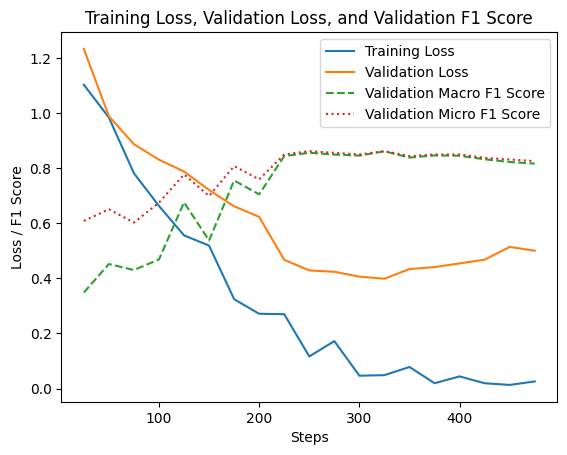

In [17]:
import matplotlib.pyplot as plt

# Extract training loss, validation loss, and F1 score
training_loss = []
validation_loss = []
validation_macro_f1 = []
validation_micro_f1 = []
eval_steps = []
train_steps = []

for log in trainer.state.log_history:
    if "loss" in log:
        training_loss.append(log["loss"])
        train_steps.append(log["step"])
    if "eval_loss" in log:
        validation_loss.append(log["eval_loss"])
        eval_steps.append(log["step"])
    if "eval_macro_f1" in log:
        validation_macro_f1.append(log["eval_macro_f1"])
    if "eval_micro_f1" in log:
        validation_micro_f1.append(log["eval_micro_f1"])

# Plot the training and validation loss
plt.plot(train_steps, training_loss, label="Training Loss")
plt.plot(eval_steps, validation_loss, label="Validation Loss")
plt.plot(eval_steps, validation_macro_f1, label="Validation Macro F1 Score", linestyle="--")
plt.plot(eval_steps, validation_micro_f1, label="Validation Micro F1 Score", linestyle="dotted")

# Set labels and title
plt.xlabel("Steps")
plt.ylabel("Loss / F1 Score")
plt.title("Training Loss, Validation Loss, and Validation F1 Score")
plt.legend()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r {experiment_full_path} /content/drive/MyDrive

In [18]:
predictions = trainer.predict(tokenized_datasets["test"])

# Extract logits and true labels
logits = predictions.predictions #(shape: [n_samples, n_classes])
true_labels = predictions.label_ids #(shape: [n_samples])
probabilities = torch.softmax(torch.tensor(logits), dim=-1).numpy()  # Shape: (n_samples, n_classes)

# Compute the F1 score using your compute_metrics function
f1_score = compute_metrics((logits, true_labels))

# Print the F1 score
f1_score

{'f1_class_0': 0.7428571428571429,
 'f1_class_1': 0.9642857142857143,
 'f1_class_2': 0.9148936170212766,
 'macro_f1': 0.8740121580547112,
 'micro_f1': 0.8853503184713376}

In [19]:
#using strategy = "quantile" strategy{‘uniform’, ‘quantile’}
def calculate_ece(y_true, y_prob, num_bins=10):
    """Compute Expected Calibration Error (ECE)"""
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=num_bins, strategy = "quantile")
    ece = np.sum(np.abs(prob_pred - prob_true) * len(y_true) / num_bins)
    return ece

def plot_reliability_diagram(y_true, y_prob, class_idx, num_bins=10):
    """Plot reliability diagram for a specific class"""
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=num_bins, strategy = "quantile")
    plt.plot(prob_pred, prob_true, marker='o', label=f'Class {class_idx}')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title(f'Reliability Diagram for Class {class_idx}')
    plt.legend()
    plt.show()

For a three-label classification problem, you can calculate the reliability diagram and Expected Calibration Error (ECE) for each class by treating the problem as multiple binary classification tasks (one-vs-rest for each class). This is typically done by transforming the problem into three binary sub-problems, one for each class.



Calculating ECE for bins=2


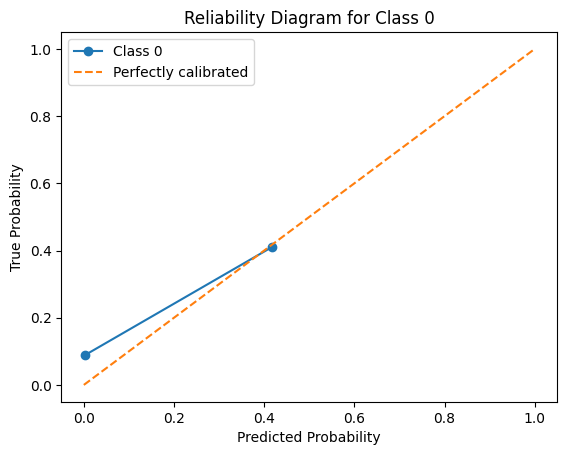

Expected Calibration Error (ECE) for Class 0 with bins=2: 7.316992992641242


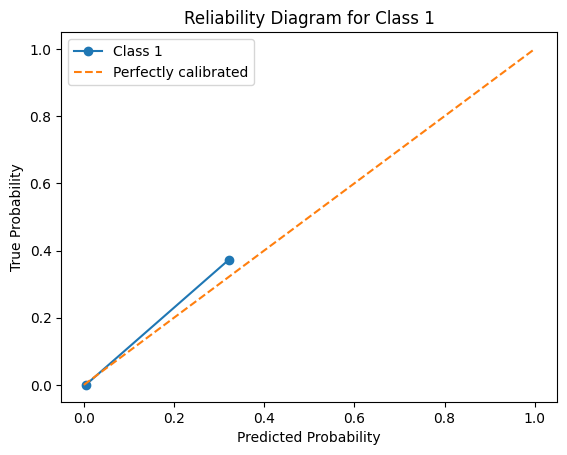

Expected Calibration Error (ECE) for Class 1 with bins=2: 4.316241988137901


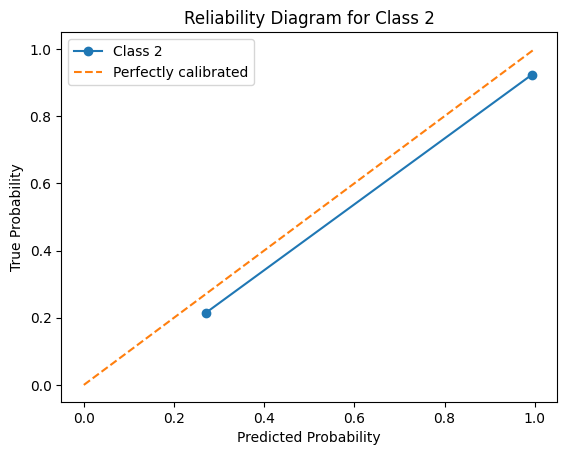

Expected Calibration Error (ECE) for Class 2 with bins=2: 9.920654155167057
Calculating ECE for bins=3


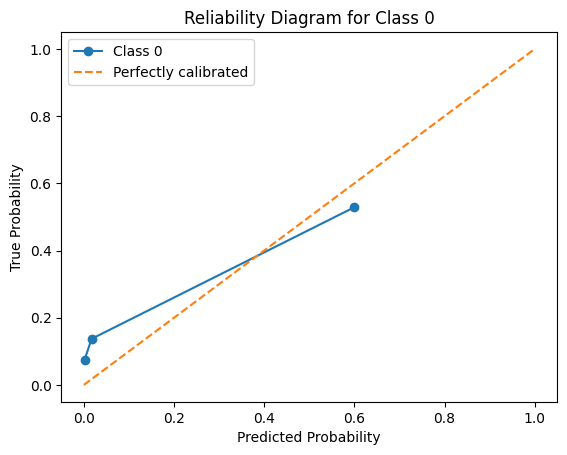

Expected Calibration Error (ECE) for Class 0 with bins=3: 13.843319583553408


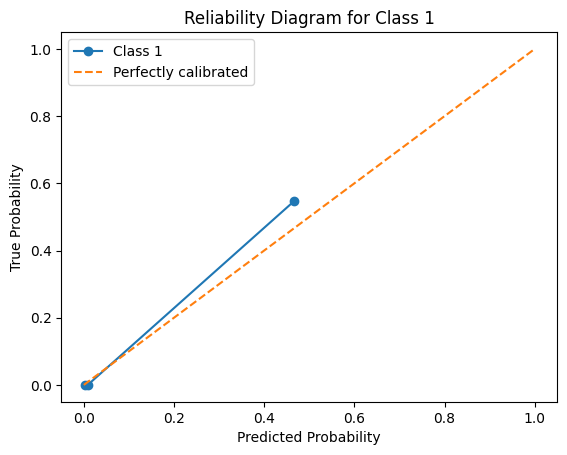

Expected Calibration Error (ECE) for Class 1 with bins=3: 4.85555046135915


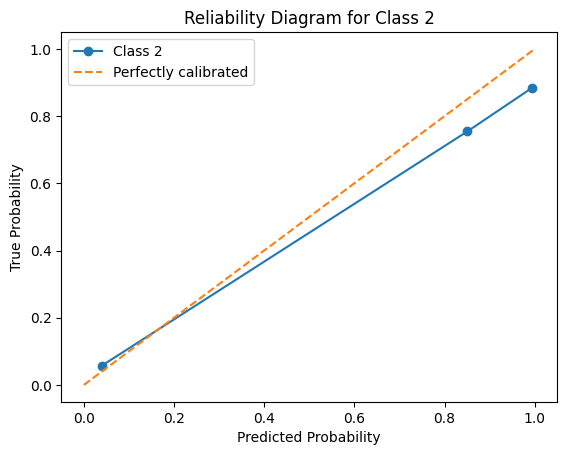

Expected Calibration Error (ECE) for Class 2 with bins=3: 11.691554907141189
Calculating ECE for bins=4


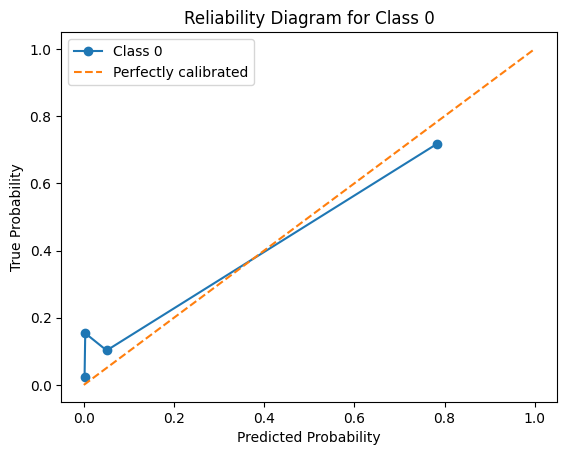

Expected Calibration Error (ECE) for Class 0 with bins=4: 11.456558323544261


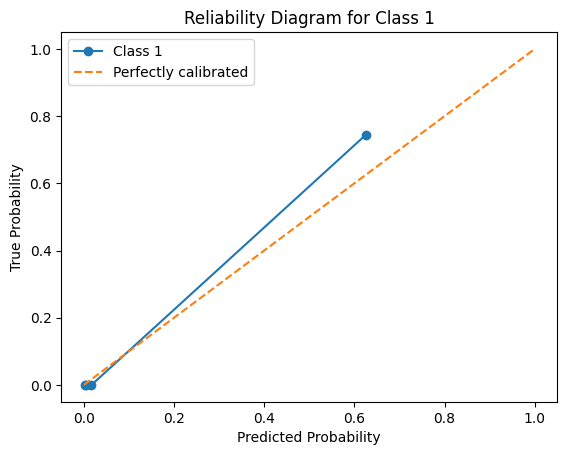

Expected Calibration Error (ECE) for Class 1 with bins=4: 5.64929405565367


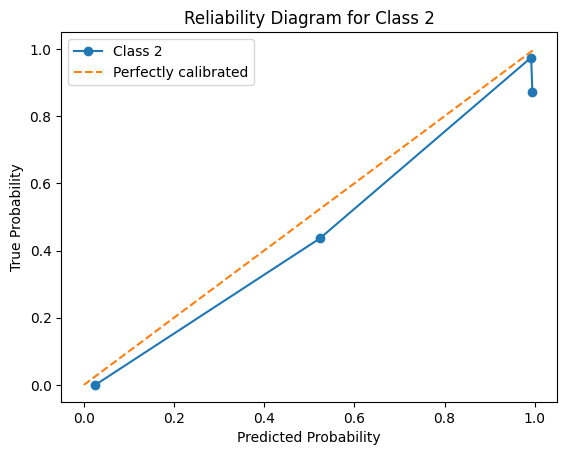

Expected Calibration Error (ECE) for Class 2 with bins=4: 9.951474578965769
Calculating ECE for bins=5


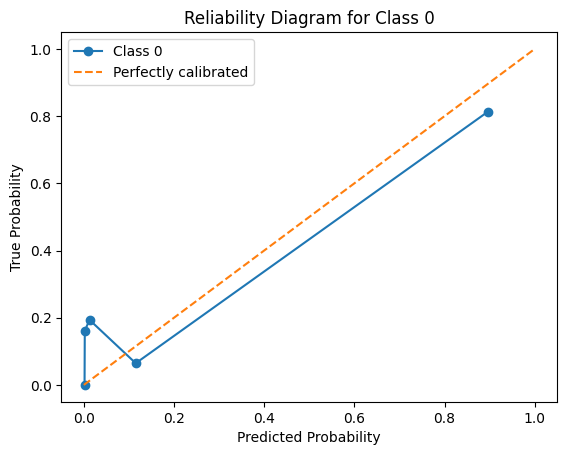

Expected Calibration Error (ECE) for Class 0 with bins=5: 14.919115320748213


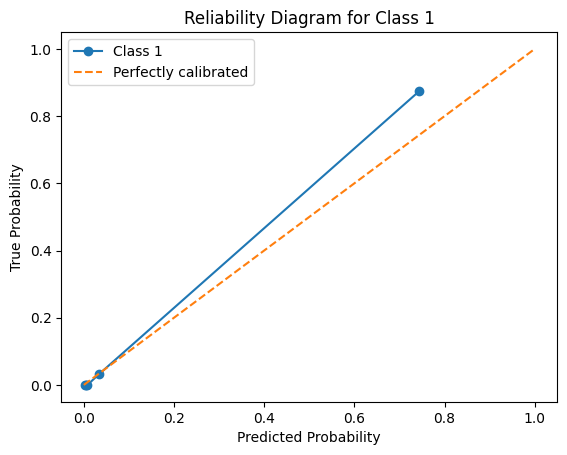

Expected Calibration Error (ECE) for Class 1 with bins=5: 4.634543611807185


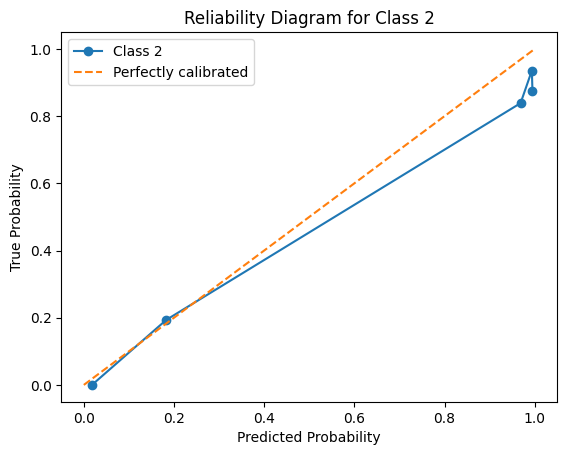

Expected Calibration Error (ECE) for Class 2 with bins=5: 10.574482839672466
Calculating ECE for bins=6


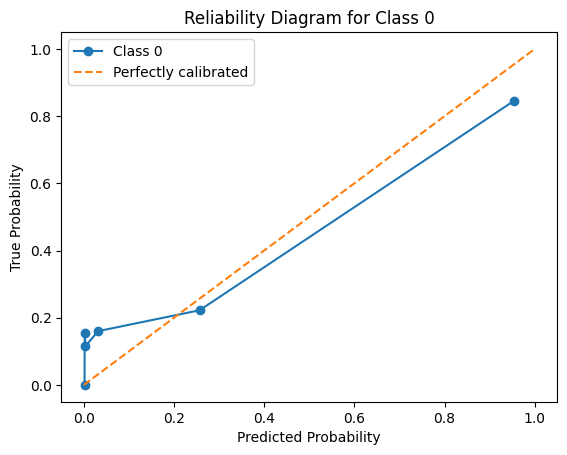

Expected Calibration Error (ECE) for Class 0 with bins=6: 14.047609914601741


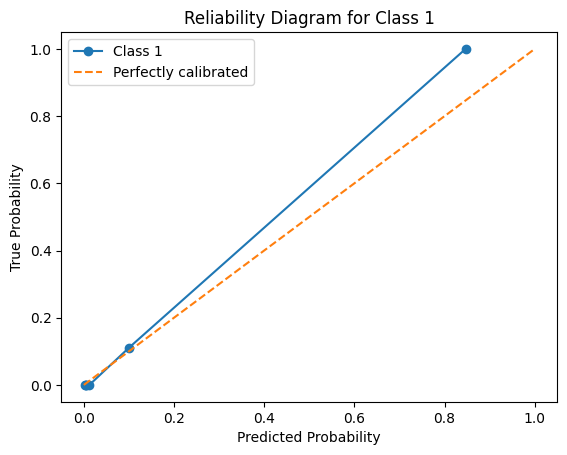

Expected Calibration Error (ECE) for Class 1 with bins=6: 4.933848804278596


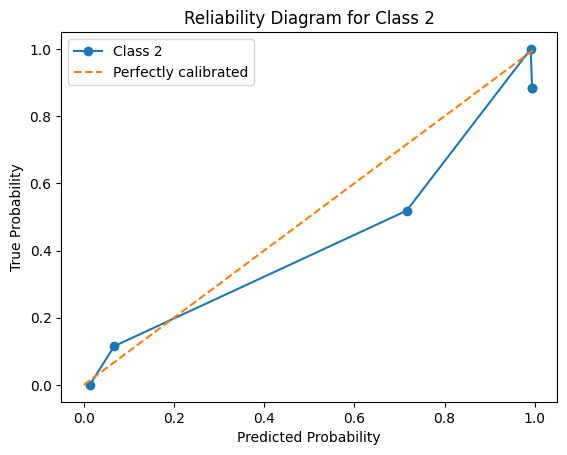

Expected Calibration Error (ECE) for Class 2 with bins=6: 12.748822076660954
Calculating ECE for bins=7


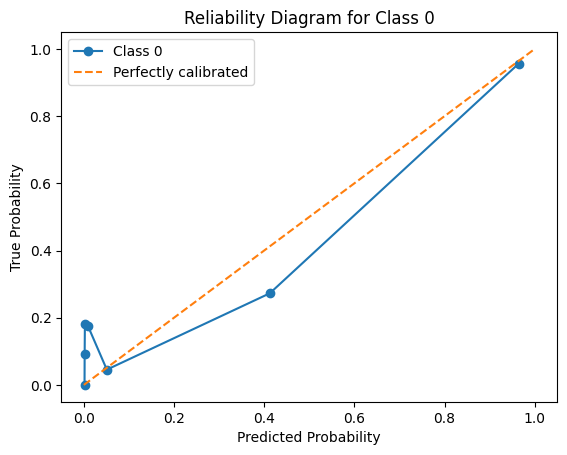

Expected Calibration Error (ECE) for Class 0 with bins=7: 13.184095418603308


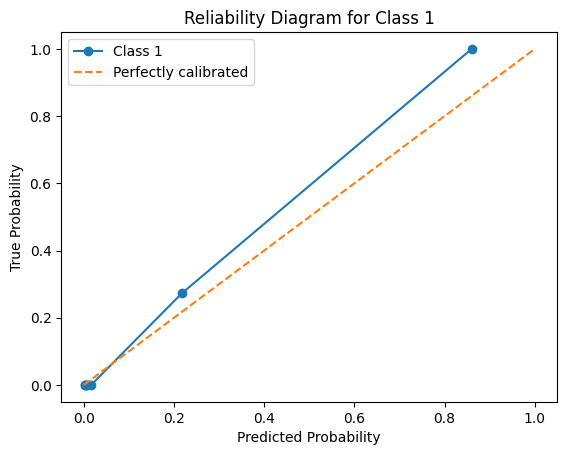

Expected Calibration Error (ECE) for Class 1 with bins=7: 5.167899136947725


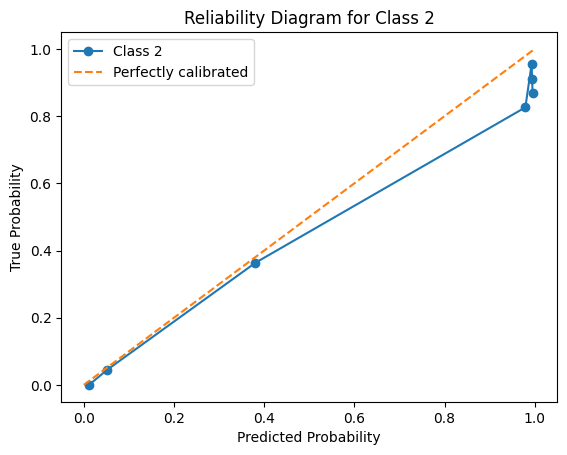

Expected Calibration Error (ECE) for Class 2 with bins=7: 9.811049229442286
Calculating ECE for bins=8


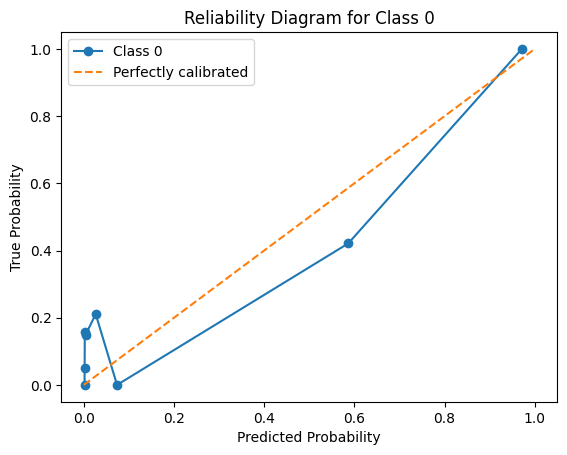

Expected Calibration Error (ECE) for Class 0 with bins=8: 15.758692283907372


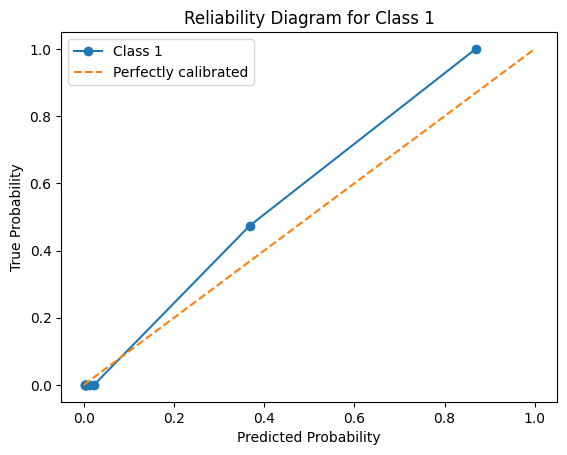

Expected Calibration Error (ECE) for Class 1 with bins=8: 5.630484842989015


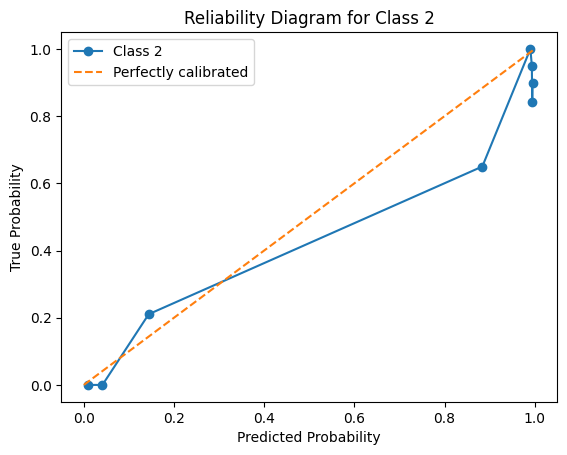

Expected Calibration Error (ECE) for Class 2 with bins=8: 12.793259632946482
Calculating ECE for bins=9


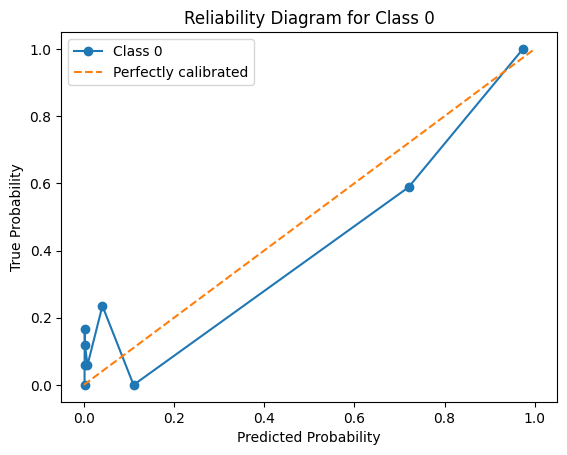

Expected Calibration Error (ECE) for Class 0 with bins=9: 14.850688754348548


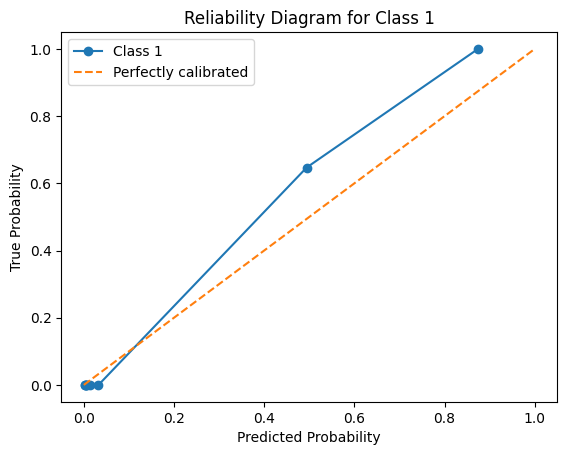

Expected Calibration Error (ECE) for Class 1 with bins=9: 6.063903232786998


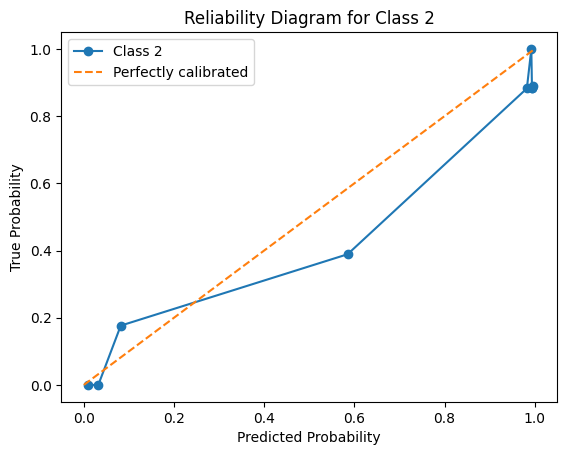

Expected Calibration Error (ECE) for Class 2 with bins=9: 13.42324518231667
Calculating ECE for bins=10


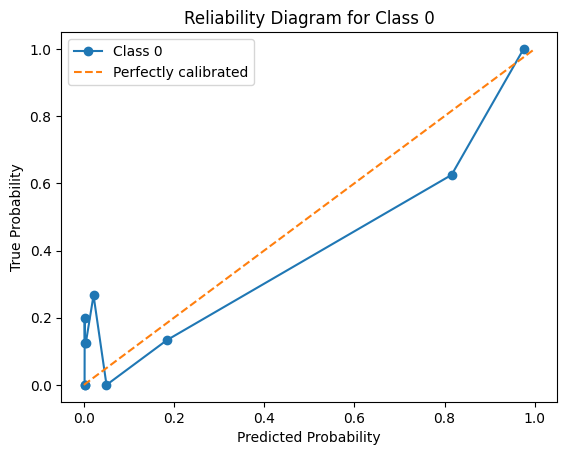

Expected Calibration Error (ECE) for Class 0 with bins=10: 15.795039421311715


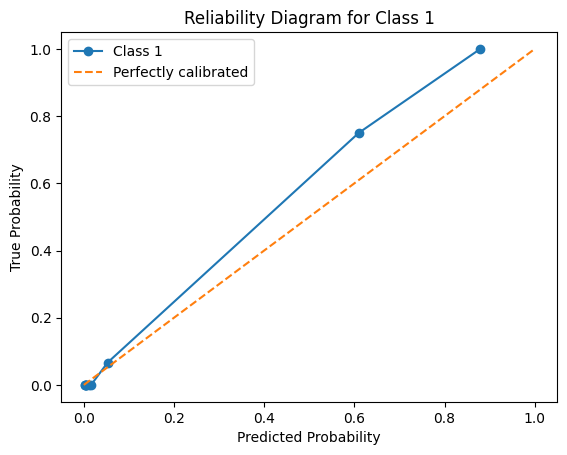

Expected Calibration Error (ECE) for Class 1 with bins=10: 5.055371496623653


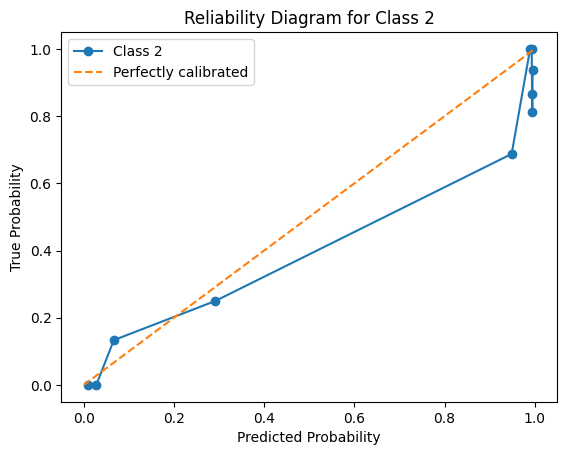

Expected Calibration Error (ECE) for Class 2 with bins=10: 12.410169629484104
ECE results for each class and each value of bins:
Class 0, Bins 2: ECE = 7.316992992641242
Class 0, Bins 3: ECE = 13.843319583553408
Class 0, Bins 4: ECE = 11.456558323544261
Class 0, Bins 5: ECE = 14.919115320748213
Class 0, Bins 6: ECE = 14.047609914601741
Class 0, Bins 7: ECE = 13.184095418603308
Class 0, Bins 8: ECE = 15.758692283907372
Class 0, Bins 9: ECE = 14.850688754348548
Class 0, Bins 10: ECE = 15.795039421311715
Class 1, Bins 2: ECE = 4.316241988137901
Class 1, Bins 3: ECE = 4.85555046135915
Class 1, Bins 4: ECE = 5.64929405565367
Class 1, Bins 5: ECE = 4.634543611807185
Class 1, Bins 6: ECE = 4.933848804278596
Class 1, Bins 7: ECE = 5.167899136947725
Class 1, Bins 8: ECE = 5.630484842989015
Class 1, Bins 9: ECE = 6.063903232786998
Class 1, Bins 10: ECE = 5.055371496623653
Class 2, Bins 2: ECE = 9.920654155167057
Class 2, Bins 3: ECE = 11.691554907141189
Class 2, Bins 4: ECE = 9.951474578965769
C

In [20]:
# Initialize a dictionary to save ECE for each class and each value of bins
ece_results = {class_idx: {} for class_idx in range(n_classes)}

# Loop over the values of bins from 2 to 10
for bins in range(2, 11):
    print(f"Calculating ECE for bins={bins}")

    # Loop over each class (0, 1, 2)
    for class_idx in range(n_classes):
        # Convert true labels to binary (1 if the true label is the current class, 0 otherwise)
        y_true_binary = (true_labels == class_idx).astype(int)

        # Extract probabilities for the current class
        y_prob = probabilities[:, class_idx]

        # Plot reliability diagram for the current class
        plot_reliability_diagram(y_true_binary, y_prob, class_idx, num_bins=bins)

        # Calculate the ECE for the current class and bin count
        ece = calculate_ece(y_true_binary, y_prob, num_bins=bins)
        print(f"Expected Calibration Error (ECE) for Class {class_idx} with bins={bins}: {ece}")

        # Save the ECE in the dictionary
        ece_results[class_idx][bins] = ece

# Display or access the saved results in ece_results
print("ECE results for each class and each value of bins:")
for class_idx, ece_per_bin in ece_results.items():
    for bin_count, ece_value in ece_per_bin.items():
        print(f"Class {class_idx}, Bins {bin_count}: ECE = {ece_value}")


